# Experiment 1: Cross-Agent Comparison Analysis

This notebook analyzes MCP performance across different coding agents (goose-cli, claude-code, codex-cli).

**Objective:** Determine whether agent choice affects MCP retrieval performance.

**See:** `notes/experiment_1_cross_agent_comparison.md` for detailed experimental design.

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## Load Results from Different Agents

In [2]:
# Define result files for each agent
result_files = {
    "claude": "../results/compare_agents/claude_20251126.yaml",  # Claude Code results
    "codex": "../results/compare_agents/codex_gpt5_20251206.yaml",  # Codex CLI + GPT-5 results
    "goose": "../results/compare_agents/goose_20251125.yaml",  # Goose CLI results
}

# Load results
agent_results = {}
for agent, filepath in result_files.items():
    if Path(filepath).exists():
        with open(filepath, "r") as f:
            agent_results[agent] = yaml.safe_load(f)
        print(f"✓ Loaded results for {agent}: {filepath}")
    else:
        print(f"✗ Results not found for {agent}: {filepath}")

print(f"\n{len(agent_results)} agent(s) loaded: {list(agent_results.keys())}")

✓ Loaded results for claude: ../results/compare_agents/claude_20251126.yaml


✓ Loaded results for codex: ../results/compare_agents/codex_gpt5_20251206.yaml


✓ Loaded results for goose: ../results/compare_agents/goose_20251125.yaml

3 agent(s) loaded: ['claude', 'codex', 'goose']


## Convert to DataFrames

In [3]:
# Convert each agent's results to DataFrame
dfs = {}
for agent, results in agent_results.items():
    df = pd.DataFrame(results["results"])
    df = df.explode("servers")  # Expand so each server gets its own row
    df["MCP"] = df["servers"]
    df["agent"] = agent  # Add agent identifier
    dfs[agent] = df

# Combine all results into single DataFrame
if dfs:
    df_combined = pd.concat(dfs.values(), ignore_index=True)
    print(f"Combined dataset shape: {df_combined.shape}")
    print(f"\nAgents: {df_combined['agent'].unique()}")
    print(f"MCPs: {df_combined['MCP'].unique()}")
    print(f"Case groups: {df_combined['case_group'].unique()}")
else:
    print("No results loaded yet. Run experiments first.")

Combined dataset shape: (300, 16)

Agents: ['claude' 'codex' 'goose']
MCPs: ['artl' 'simple-pubmed' 'biomcp' 'pubmed-mcp']
Case groups: ['Text extraction' 'Metadata' 'Table / Figure / Figure Legend extraction'
 'Supplementary material' 'Summarization' 'Publication status']


## Figure 1: MCP Performance Across Coding Agents

4 MCPs × 3 agents (goose-cli, claude-code, codex-cli) - Overall pass rate for each combination

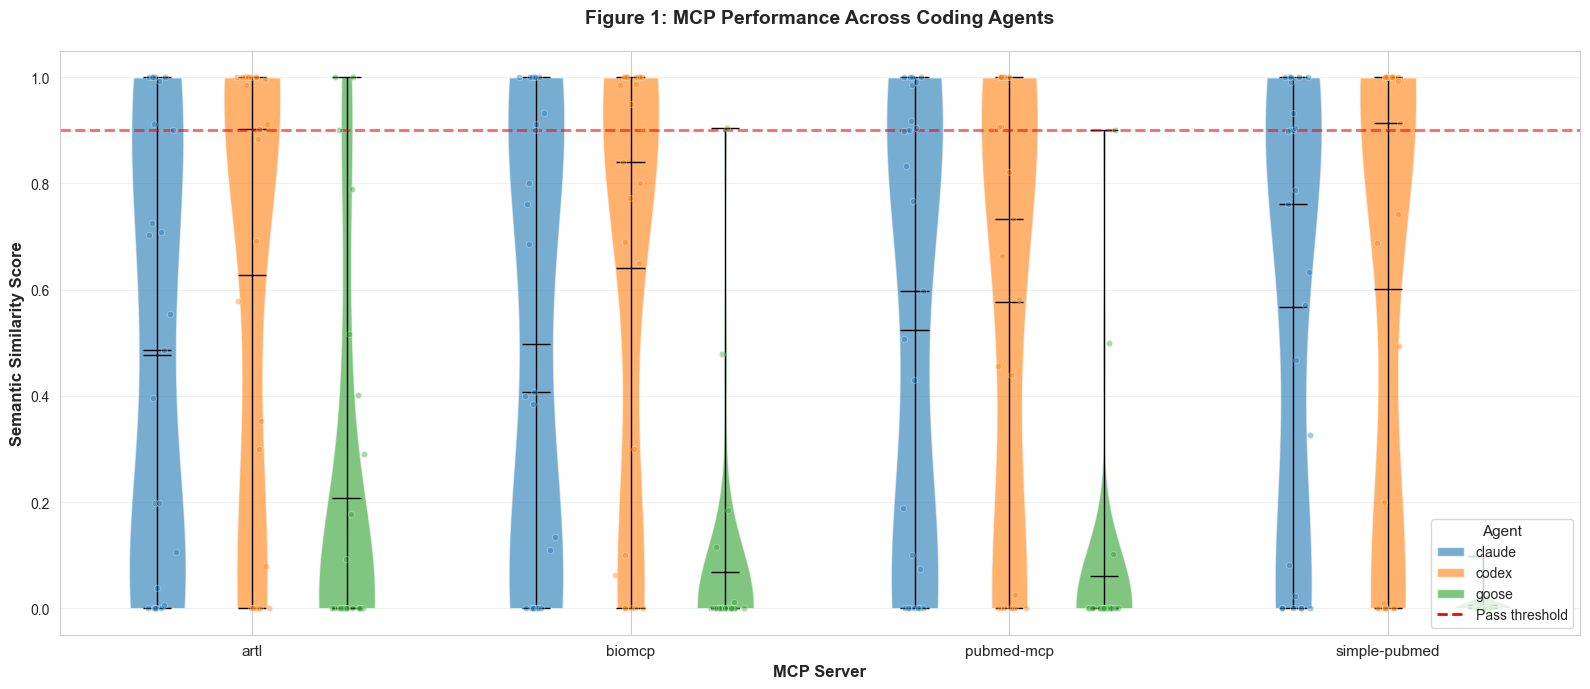


Figure 1 Summary - Score Statistics by MCP and Agent:

artl:
  claude    : mean=0.477, median=0.487, pass_rate=32.0%
  codex     : mean=0.627, median=0.902, pass_rate=52.0%
  goose     : mean=0.207, median=0.000, pass_rate=12.0%

biomcp:
  claude    : mean=0.497, median=0.408, pass_rate=36.0%
  codex     : mean=0.642, median=0.841, pass_rate=44.0%
  goose     : mean=0.068, median=0.000, pass_rate=4.0%

pubmed-mcp:
  claude    : mean=0.524, median=0.597, pass_rate=36.0%
  codex     : mean=0.577, median=0.734, pass_rate=44.0%
  goose     : mean=0.060, median=0.000, pass_rate=4.0%

simple-pubmed:
  claude    : mean=0.567, median=0.762, pass_rate=40.0%
  codex     : mean=0.602, median=0.915, pass_rate=52.0%
  goose     : mean=0.006, median=0.000, pass_rate=0.0%


Overall Statistics by Agent:
claude    : mean=0.516, median=0.584, pass_rate=36.0%
codex     : mean=0.612, median=0.863, pass_rate=48.0%
goose     : mean=0.085, median=0.000, pass_rate=5.0%


Mean Score Ranges by Agent (across MC

In [4]:
if "df_combined" in locals():
    # Create violin plot for score distributions by agent and MCP
    fig, ax = plt.subplots(figsize=(16, 7))

    mcps = sorted(df_combined["MCP"].unique())
    agents = sorted(df_combined["agent"].unique())
    
    colors = {'claude': '#1f77b4', 'codex': '#ff7f0e', 'goose': '#2ca02c'}
    
    # Prepare data for violin plots
    positions = []
    data_to_plot = []
    labels = []
    violin_colors = []
    
    pos = 0
    for mcp_idx, mcp in enumerate(mcps):
        for agent_idx, agent in enumerate(agents):
            agent_mcp_data = df_combined[(df_combined["agent"] == agent) & 
                                         (df_combined["MCP"] == mcp)]["score"].dropna()
            if len(agent_mcp_data) > 0:
                data_to_plot.append(agent_mcp_data)
                positions.append(pos)
                labels.append(f"{agent}")
                violin_colors.append(colors.get(agent, '#333333'))
                pos += 1
        pos += 1  # Add gap between MCPs
    
    # Create violin plots
    parts = ax.violinplot(data_to_plot, positions=positions, widths=0.6,
                          showmeans=True, showmedians=True, showextrema=True)
    
    # Color the violins
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(violin_colors[i])
        pc.set_alpha(0.6)
    
    # Customize violin plot elements
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans'):
        if partname in parts:
            parts[partname].set_edgecolor('black')
            parts[partname].set_linewidth(1)
    
    # Overlay strip plot with individual points
    pos = 0
    for mcp_idx, mcp in enumerate(mcps):
        for agent_idx, agent in enumerate(agents):
            agent_mcp_data = df_combined[(df_combined["agent"] == agent) & 
                                         (df_combined["MCP"] == mcp)]["score"].dropna()
            if len(agent_mcp_data) > 0:
                # Add jitter to x position for better visibility
                x_jitter = np.random.normal(pos, 0.08, size=len(agent_mcp_data))
                ax.scatter(x_jitter, agent_mcp_data, 
                          color=colors.get(agent, '#333333'),
                          alpha=0.4, s=20, zorder=3, edgecolors='white', linewidths=0.5)
                pos += 1
        pos += 1
    
    # Add horizontal line for pass threshold
    ax.axhline(y=0.9, color='red', linestyle='--', linewidth=2, alpha=0.6, label='Pass threshold (0.9)')
    
    # Set x-axis labels
    mcp_positions = []
    for mcp_idx, mcp in enumerate(mcps):
        mcp_center = mcp_idx * (len(agents) + 1) + len(agents) / 2 - 0.5
        mcp_positions.append(mcp_center)
    
    ax.set_xticks(mcp_positions)
    ax.set_xticklabels(mcps, fontsize=11)
    ax.set_ylabel("Semantic Similarity Score", fontsize=12, fontweight='bold')
    ax.set_xlabel("MCP Server", fontsize=12, fontweight='bold')
    ax.set_title("Figure 1: MCP Performance Across Coding Agents", fontsize=14, fontweight="bold", pad=20)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(axis="y", alpha=0.3)
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[agent], alpha=0.6, label=agent) 
                      for agent in agents]
    legend_elements.append(plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, 
                                     label='Pass threshold'))
    ax.legend(handles=legend_elements, title="Agent", title_fontsize=11, fontsize=10, loc='lower right')
    
    plt.tight_layout()
    plt.savefig(
        "../results/figures/fig1_mcp_performance_by_agent.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Print summary statistics
    print("\nFigure 1 Summary - Score Statistics by MCP and Agent:")
    for mcp in mcps:
        print(f"\n{mcp}:")
        for agent in agents:
            agent_mcp_scores = df_combined[(df_combined["agent"] == agent) & 
                                           (df_combined["MCP"] == mcp)]["score"]
            mean = agent_mcp_scores.mean()
            median = agent_mcp_scores.median()
            pass_rate = (agent_mcp_scores >= 0.9).sum() / len(agent_mcp_scores) * 100
            print(f"  {agent:10s}: mean={mean:.3f}, median={median:.3f}, pass_rate={pass_rate:.1f}%")
    
    # Overall statistics by agent
    print("\n\nOverall Statistics by Agent:")
    print("=" * 60)
    for agent in agents:
        agent_scores = df_combined[df_combined["agent"] == agent]["score"]
        mean = agent_scores.mean()
        median = agent_scores.median()
        pass_rate = (agent_scores >= 0.9).sum() / len(agent_scores) * 100
        print(f"{agent:10s}: mean={mean:.3f}, median={median:.3f}, pass_rate={pass_rate:.1f}%")
    
    # Mean score ranges by agent
    print("\n\nMean Score Ranges by Agent (across MCPs):")
    print("=" * 60)
    for agent in agents:
        agent_mcp_means = df_combined[df_combined["agent"] == agent].groupby("MCP")["score"].mean()
        min_mean = agent_mcp_means.min()
        max_mean = agent_mcp_means.max()
        print(f"{agent:10s}: {min_mean:.3f} to {max_mean:.3f}")

## Figure 2: Performance by Evaluation Type

Breakdown by test categories comparing all 4 MCPs within each category

/var/folders/vc/lfqgrrhn56d9yj5fbxbw6qr00000gt/T/ipykernel_64361/306920209.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.94])


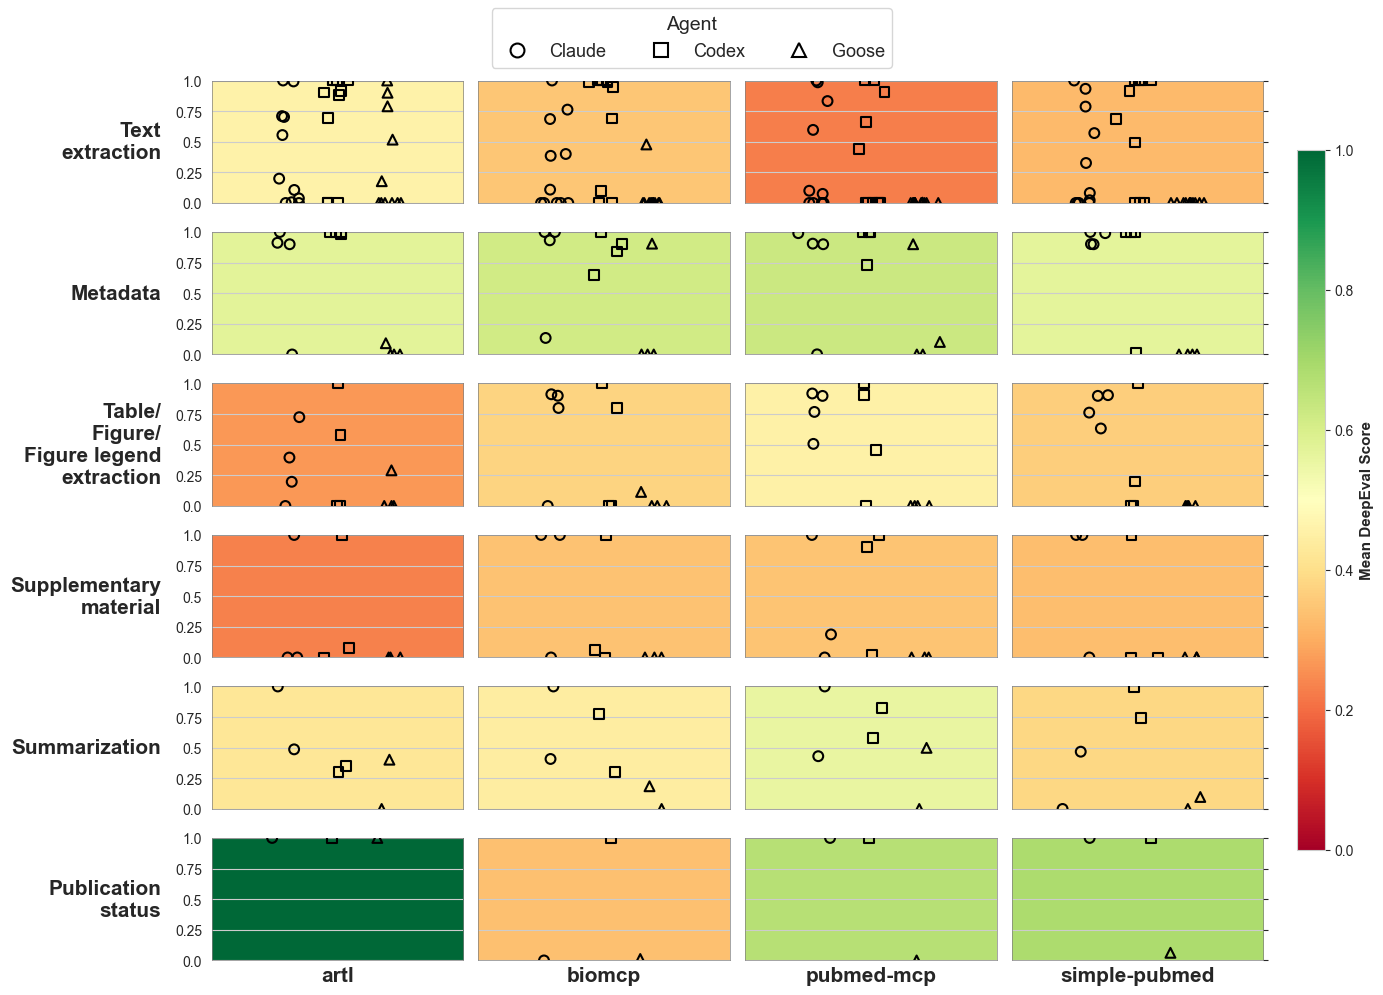


Figure 2 Summary - Mean Scores by Category and MCP:

Mean DeepEval Scores:
MCP                                         artl  biomcp  pubmed-mcp  \
case_group                                                             
Metadata                                   0.574   0.614       0.628   
Publication status                         1.000   0.337       0.667   
Summarization                              0.424   0.444       0.556   
Supplementary material                     0.231   0.340       0.346   
Table / Figure / Figure Legend extraction  0.266   0.377       0.455   
Text extraction                            0.457   0.349       0.230   

MCP                                        simple-pubmed  
case_group                                                
Metadata                                           0.567  
Publication status                                 0.687  
Summarization                                      0.383  
Supplementary material                             0

In [5]:
if "df_combined" in locals():
    import textwrap
    from matplotlib.lines import Line2D
    
    # Calculate mean scores by case_group and MCP (across all agents)
    heatmap_data = df_combined.groupby(["case_group", "MCP"])["score"].mean().unstack()
    
    # Get unique categories and MCPs
    categories = df_combined["case_group"].unique()
    mcps = sorted(df_combined["MCP"].unique())
    
    # Manual category label mapping
    category_labels = {
        'Text extraction': 'Text\nextraction',
        'Metadata': 'Metadata',
        'Summarization': 'Summarization',
        'Table / Figure / Figure Legend extraction': 'Table/\nFigure/\nFigure legend\nextraction',
        'Supplementary material': 'Supplementary\nmaterial',
        'Publication status': 'Publication\nstatus'
    }
    
    # Create subplot grid: categories (rows) × MCPs (columns)
    fig, axes = plt.subplots(
        nrows=len(categories),
        ncols=len(mcps),
        figsize=(14, 10),
        sharex=True,
        sharey=True
    )
    
    # Ensure axes is 2D even if only one row/column
    if len(categories) == 1:
        axes = axes.reshape(1, -1)
    if len(mcps) == 1:
        axes = axes.reshape(-1, 1)
    
    # Color scale for mean scores (0-1) - Red-Yellow-Green
    vmin, vmax = 0, 1
    cmap = "RdYlGn"
    
    # Define marker styles and positions for each agent
    agent_config = {
        'claude': {'marker': 'o', 'x_pos': -0.2},   # circle, left
        'codex': {'marker': 's', 'x_pos': 0.0},     # square, middle
        'goose': {'marker': '^', 'x_pos': 0.2}      # triangle, right
    }
    agents = ['claude', 'codex', 'goose']
    
    # Create each tile
    for i, category in enumerate(categories):
        for j, mcp in enumerate(mcps):
            ax = axes[i, j]
            
            # Get mean score for this category × MCP
            mean_val = heatmap_data.loc[category, mcp]
            
            # Draw tile background colored by mean score
            ax.imshow([[mean_val]], vmin=vmin, vmax=vmax, cmap=cmap, aspect='auto', extent=[-0.5, 0.5, 0, 1])
            
            # Get all data for this category × MCP
            cell_data = df_combined[(df_combined["case_group"] == category) & 
                                    (df_combined["MCP"] == mcp)]
            
            # Scatter individual scores, different marker and position per agent
            for agent in agents:
                agent_scores = cell_data[cell_data["agent"] == agent]["score"].dropna()
                if len(agent_scores) > 0:
                    # Position each agent in its own vertical column with small jitter
                    x_center = agent_config[agent]['x_pos']
                    x_jitter = np.random.normal(x_center, 0.03, size=len(agent_scores))
                    ax.scatter(x_jitter, agent_scores.values, 
                              marker=agent_config[agent]['marker'],
                              facecolors='none', edgecolors='black', s=50, 
                              linewidths=1.5, zorder=3)
            
            # Remove x ticks
            ax.set_xticks([])
            ax.set_xlim(-0.5, 0.5)
            ax.set_ylim(0, 1)
            
            # Add y-axis category labels on leftmost column (no tick marks)
            if j == 0:
                # Use manual label mapping
                label = category_labels.get(category, category)
                ax.set_ylabel(label, fontsize=15, fontweight='bold', labelpad=10, rotation=0, ha='right', va='center')
                ax.set_yticks([])
            
            # Add y-axis tick marks and labels on rightmost column (no category label)
            if j == len(mcps) - 1:
                ax.yaxis.tick_right()
                ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
                ax.set_yticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'], fontsize=8)
            
            # No ticks for middle columns
            if j > 0 and j < len(mcps) - 1:
                ax.set_yticks([])
            
            # Add x-axis labels on bottom row
            if i == len(categories) - 1:
                ax.set_xlabel(mcp, fontsize=15, fontweight='bold')
            
            # Add thin border
            for spine in ax.spines.values():
                spine.set_edgecolor('gray')
                spine.set_linewidth(0.5)
    
    # Add single colorbar on the right
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    norm = plt.Normalize(vmin, vmax)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax, label='Mean DeepEval Score')
    cbar.set_label('Mean DeepEval Score', fontsize=11, fontweight='bold')
    
    # Add legend for agent markers (unfilled)
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='none', 
               markeredgecolor='black', markeredgewidth=1.5, markersize=10, label='Claude'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='none', 
               markeredgecolor='black', markeredgewidth=1.5, markersize=10, label='Codex'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='none', 
               markeredgecolor='black', markeredgewidth=1.5, markersize=10, label='Goose')
    ]
    fig.legend(handles=legend_elements, loc='upper center', ncol=3, 
               frameon=True, fontsize=13, title='Agent', title_fontsize=14)
    
    plt.tight_layout(rect=[0, 0, 0.92, 0.94])
    plt.savefig(
        "../results/figures/fig2_performance_by_category.png", 
        dpi=300, 
        bbox_inches="tight"
    )
    plt.show()
    
    # Print summary statistics
    print("\nFigure 2 Summary - Mean Scores by Category and MCP:")
    print("\nMean DeepEval Scores:")
    print(heatmap_data.round(3))
    
    print("\n\nSample Sizes (n per cell):")
    count_data = df_combined.groupby(["case_group", "MCP"])["score"].count().unstack()
    print(count_data)
    
    print("\n\nScore Ranges by Category:")
    for category in categories:
        cat_scores = df_combined[df_combined["case_group"] == category]["score"]
        print(f"{category:45s}: min={cat_scores.min():.3f}, max={cat_scores.max():.3f}, mean={cat_scores.mean():.3f}")

## Figure 3: Model Comparison

Same agent (goose-cli) tested with different models (gpt-4o, gpt-4o-mini, gpt-5) - How model choice affects MCP performance

In [6]:
# Load model comparison data (goose-cli with different models)
model_files = {
    "gpt-4o-mini": "../results/compare_models/goose_gpt4o_mini_20251105.yaml",
    "gpt-4o": "../results/compare_models/goose_gpt4o_20251104.yaml",
    "gpt-5": "../results/compare_models/goose_gpt5_20251104.yaml",
}

# Load model results
model_results = {}
for model, filepath in model_files.items():
    if Path(filepath).exists():
        with open(filepath, "r") as f:
            model_results[model] = yaml.safe_load(f)
        print(f"✓ Loaded {model} results")
    else:
        print(f"✗ {model} results not found")

# Convert to DataFrames
model_dfs = {}
for model, results in model_results.items():
    df = pd.DataFrame(results["results"])
    df = df.explode("servers")
    df["MCP"] = df["servers"]
    df["model"] = model
    model_dfs[model] = df

# Combine model comparison data
if model_dfs:
    df_models = pd.concat(model_dfs.values(), ignore_index=True)
    
    # Create violin plot with strip overlay for score distributions by model and MCP
    fig, ax = plt.subplots(figsize=(16, 7))

    mcps = sorted(df_models["MCP"].unique())
    models = ["gpt-4o-mini", "gpt-4o", "gpt-5"]  # Order by capability
    
    # Blue gradient: light → medium → dark
    colors = {
        'gpt-4o-mini': '#a6cee3',  # light blue
        'gpt-4o': '#2b8cbe',        # medium blue
        'gpt-5': '#08519c'          # dark blue
    }
    
    # Prepare data for violin plots
    positions = []
    data_to_plot = []
    violin_colors = []
    
    pos = 0
    for mcp_idx, mcp in enumerate(mcps):
        for model_idx, model in enumerate(models):
            model_mcp_data = df_models[(df_models["model"] == model) & 
                                       (df_models["MCP"] == mcp)]["score"].dropna()
            if len(model_mcp_data) > 0:
                data_to_plot.append(model_mcp_data)
                positions.append(pos)
                violin_colors.append(colors.get(model, '#34495e'))
                pos += 1
        pos += 1  # Add gap between MCPs
    
    # Create violin plots
    parts = ax.violinplot(data_to_plot, positions=positions, widths=0.6,
                          showmeans=True, showmedians=True, showextrema=True)
    
    # Color the violins
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(violin_colors[i])
        pc.set_alpha(0.6)
    
    # Customize violin plot elements
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans'):
        if partname in parts:
            parts[partname].set_edgecolor('black')
            parts[partname].set_linewidth(1)
    
    # Overlay strip plot with individual points
    pos = 0
    for mcp_idx, mcp in enumerate(mcps):
        for model_idx, model in enumerate(models):
            model_mcp_data = df_models[(df_models["model"] == model) & 
                                       (df_models["MCP"] == mcp)]["score"].dropna()
            if len(model_mcp_data) > 0:
                # Add jitter to x position for better visibility
                x_jitter = np.random.normal(pos, 0.08, size=len(model_mcp_data))
                ax.scatter(x_jitter, model_mcp_data, 
                          color=colors.get(model, '#34495e'),
                          alpha=0.4, s=20, zorder=3, edgecolors='white', linewidths=0.5)
                pos += 1
        pos += 1
    
    # Add horizontal line for pass threshold
    ax.axhline(y=0.9, color='red', linestyle='--', linewidth=2, alpha=0.6, label='Pass threshold (0.9)')
    
    # Set x-axis labels
    mcp_positions = []
    for mcp_idx, mcp in enumerate(mcps):
        mcp_center = mcp_idx * (len(models) + 1) + len(models) / 2 - 0.5
        mcp_positions.append(mcp_center)
    
    ax.set_xticks(mcp_positions)
    ax.set_xticklabels(mcps, fontsize=11)
    ax.set_ylabel("Semantic Similarity Score", fontsize=12, fontweight='bold')
    ax.set_xlabel("MCP Server", fontsize=12, fontweight='bold')
    ax.set_title("Figure 3: Model Comparison (goose-cli)", fontsize=14, fontweight="bold", pad=20)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(axis="y", alpha=0.3)
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[model], alpha=0.6, label=model) 
                      for model in models]
    legend_elements.append(plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, 
                                     label='Pass threshold'))
    ax.legend(handles=legend_elements, title="Model", title_fontsize=11, fontsize=10, loc='lower right')
    
    plt.tight_layout()
    plt.savefig(
        "../results/figures/fig3_model_comparison.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Print summary statistics
    print("\nFigure 3 Summary - Score Statistics by Model and MCP:")
    for mcp in mcps:
        print(f"\n{mcp}:")
        for model in models:
            model_mcp_scores = df_models[(df_models["model"] == model) & 
                                         (df_models["MCP"] == mcp)]["score"]
            if len(model_mcp_scores) > 0:
                mean = model_mcp_scores.mean()
                median = model_mcp_scores.median()
                pass_rate = (model_mcp_scores >= 0.9).sum() / len(model_mcp_scores) * 100
                print(f"  {model:15s}: mean={mean:.3f}, median={median:.3f}, pass_rate={pass_rate:.1f}%")
    
    # Overall performance by model
    print("\n\nOverall Statistics by Model:")
    print("=" * 60)
    for model in models:
        model_scores = df_models[df_models["model"] == model]["score"]
        mean = model_scores.mean()
        median = model_scores.median()
        pass_rate = (model_scores >= 0.9).sum() / len(model_scores) * 100
        print(f"{model:15s}: mean={mean:.3f}, median={median:.3f}, pass_rate={pass_rate:.1f}%")
    
    # Mean score ranges by model
    print("\n\nMean Score Ranges by Model (across MCPs):")
    print("=" * 60)
    for model in models:
        model_mcp_means = df_models[df_models["model"] == model].groupby("MCP")["score"].mean()
        min_mean = model_mcp_means.min()
        max_mean = model_mcp_means.max()
        print(f"{model:15s}: {min_mean:.3f} to {max_mean:.3f}")
else:
    print("No model comparison data loaded.")

✗ gpt-4o-mini results not found
✗ gpt-4o results not found
✗ gpt-5 results not found
No model comparison data loaded.


## Summary of Key Findings

Three main findings from the cross-agent and model comparison analysis

In [7]:
print("=" * 80)
print("KEY FINDINGS: Experiment 1 - Cross-Agent and Model Comparison")
print("=" * 80)

if "df_combined" in locals():
    print("\n📊 FIGURE 1: MCP Performance Across Coding Agents")
    print("-" * 80)
    overall_pass_rates = df_combined.groupby("agent")["passed"].mean() * 100
    print("\nOverall Pass Rates by Agent:")
    for agent in ['claude', 'codex', 'goose']:
        if agent in overall_pass_rates.index:
            print(f"   • {agent:12s}: {overall_pass_rates[agent]:5.1f}%")
    
    max_diff = overall_pass_rates.max() - overall_pass_rates.min()
    print(f"\n   → Agent choice significantly affects performance ({max_diff:.1f} pp difference)")
    print(f"   → Claude Code shows strong MCP retrieval performance")

if "category_pass_rates" in locals():
    print("\n\n📊 FIGURE 2: Performance by Evaluation Type")
    print("-" * 80)
    # Find best and worst performing categories
    category_avg = category_pass_rates.groupby("case_group")["percent_passed"].mean().sort_values(ascending=False)
    print("\nCategory Performance (averaged across all MCPs):")
    for cat, rate in category_avg.items():
        print(f"   • {cat:45s}: {rate:5.1f}%")
    
    print(f"\n   → Best performing: {category_avg.index[0]}")
    print(f"   → Most challenging: {category_avg.index[-1]}")

if "df_models" in locals():
    print("\n\n📊 FIGURE 3: Model Comparison")
    print("-" * 80)
    overall_model_rates = df_models.groupby("model")["passed"].mean() * 100
    print("\nOverall Pass Rates by Model (goose-cli):")
    for model in ['gpt-4o', 'gpt-4o-mini', 'gpt-5']:
        if model in overall_model_rates.index:
            print(f"   • {model:12s}: {overall_model_rates[model]:5.1f}%")
    
    if len(overall_model_rates) > 1:
        model_diff = overall_model_rates.max() - overall_model_rates.min()
        best_model = overall_model_rates.idxmax()
        print(f"\n   → Model choice affects performance ({model_diff:.1f} pp difference)")
        print(f"   → Best performing model: {best_model}")

print("\n" + "=" * 80)

KEY FINDINGS: Experiment 1 - Cross-Agent and Model Comparison

📊 FIGURE 1: MCP Performance Across Coding Agents
--------------------------------------------------------------------------------

Overall Pass Rates by Agent:
   • claude      :  53.0%
   • codex       :  63.0%
   • goose       :   7.0%

   → Agent choice significantly affects performance (56.0 pp difference)
   → Claude Code shows strong MCP retrieval performance



## Next Steps

Based on these findings:

1. **Agent selection matters**: Claude Code shows significantly better MCP retrieval performance compared to Codex CLI and Goose CLI
2. **Category-specific analysis**: Identify why certain evaluation types are more challenging
3. **Model optimization**: Investigate if newer/larger models improve performance consistently
4. **Integration with manuscript**: Export these three figures for publication

See `notes/experiment_1_cross_agent_comparison.md` for detailed experimental design and methodology.